<a href="https://colab.research.google.com/github/MangoHaha/NLP-dependency-parsing/blob/master/Dependency_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyspark
 

    100% |████████████████████████████████| 193.9MB 80kB/s 
    100% |████████████████████████████████| 204kB 27.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/dc/0e/02/e9fdf0bf3ad20284175307d4ab31afcf967604f25f3b4f1d96
Successfully built pyspark


In [0]:
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "Data Prepare")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np


In [0]:
class DataSet:
  def __init__ (self):
    self.dev_data = pd.read_csv('/content/drive/My Drive/NLP/data/dev.data', sep=" ", header=None)
    self.train_data = pd.read_csv('/content/drive/My Drive/NLP/data/train.data', sep=" ", header=None)
    self.vocabs_action = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.actions', sep=" ", header=None)
    self.vocabs_pos = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.pos', sep=" ", header=None)
    self.vocabs_label = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.labels', sep=" ", header=None)
    self.vocabs_word = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.word', sep=" ", header=None)
    self.word_train = self.prepare_data(train_data, vocabs_word, 0, 20)
    self.pos_train = self.prepare_data(train_data, vocabs_pos, 20, 40)
    self.label_train = self.prepare_data(train_data, vocabs_label, 40, 52)
    self.action_train = self.prepare_data(train_data, vocabs_action, 52, 53)
    self.word_dev = self.prepare_data(dev_data, vocabs_word, 0, 20)
    self.pos_dev = self.prepare_data(dev_data, vocabs_pos, 20, 40)
    self.label_dev = self.prepare_data(dev_data, vocabs_label, 40, 52)
    self.action_dev = self.prepare_data(dev_data, vocabs_action, 52, 53)

  def prepare_data(self, data, vocabs, start, end):
    sub_data = data.iloc[:,start:end]
    voc = dict(zip(vocabs.iloc[:,0], vocabs.iloc[:,1]))
    new_array = []
    #for line in sub_data.head(20).itertuples():
    for line in sub_data.itertuples():
      cur_array = []
      for word in line[1:]:
        if word in voc:
          cur_array.append(voc.get(word))
        else:
          cur_array.append(0)
      new_array.append(cur_array)
    return pd.DataFrame(new_array)

In [0]:
class NetProperties:
    def __init__(self, word_embed_dim, pos_embed_dim, label_embed_dim, hidden_dim, minibatch_size, epoch):
        self.word_embed_dim = word_embed_dim
        self.pos_embed_dim = pos_embed_dim
        self.label_embed_dim = label_embed_dim
        self.hidden_dim = hidden_dim
        self.minibatch_size = minibatch_size
        self.epoch = epoch

In [9]:
!pip install dynet


    100% |████████████████████████████████| 27.9MB 962kB/s 


In [0]:
import dynet as dynet
import random
import matplotlib.pyplot as plt
import numpy as np

class Network:
    def __init__(self, properties, dataset):
        self.properties = properties
        self.dataset = dataset

        # first initialize a computation graph container (or model).
        self.model = dynet.Model()

        # assign the algorithm for backpropagation updates.
        self.updater = dynet.AdamTrainer(self.model)

        # create embeddings for words and tag features.
        self.word_embedding = self.model.add_lookup_parameters((dataset.vocabs_word.shape[0], properties.word_embed_dim))
        self.pos_embedding = self.model.add_lookup_parameters((dataset.vocabs_pos.shape[0], properties.pos_embed_dim))
        self.label_embedding = self.model.add_lookup_parameters((dataset.vocabs_label.shape[0], properties.label_embed_dim))


        # assign transfer function
        self.transfer = dynet.rectify  # can be dynet.logistic or dynet.tanh as well.

        # define the input dimension for the embedding layer.
        # here we assume to see two words after and before and current word (meaning 5 word embeddings)
        # and to see the last two predicted tags (meaning two tag embeddings)
        #self.input_dim = 5 * properties.word_embed_dim + 2 * properties.pos_embed_dim
        self.input_dim = 20 * (properties.word_embed_dim + properties.pos_embed_dim) + 12*properties.label_embed_dim


        # define the hidden layer.
        self.hidden_layer1 = self.model.add_parameters((properties.hidden_dim, self.input_dim))

        # define the hidden layer bias term and initialize it as constant 0.2.
        self.hidden_layer_bias1 = self.model.add_parameters(properties.hidden_dim, init=dynet.ConstInitializer(0.2))
        
        # define the hidden layer.
        self.hidden_layer2 = self.model.add_parameters((properties.hidden_dim, properties.hidden_dim))

        # define the hidden layer bias term and initialize it as constant 0.2.
        self.hidden_layer_bias2 = self.model.add_parameters(properties.hidden_dim, init=dynet.ConstInitializer(0.2))

        # define the output weight.
        self.output_layer = self.model.add_parameters((dataset.vocabs_action.shape[0], properties.hidden_dim))

        # define the bias vector and initialize it as zero.
        self.output_bias = self.model.add_parameters(dataset.vocabs_action.shape[0], init=dynet.ConstInitializer(0))

    def build_graph(self,index, word, pos, label):

        # extract word embeddings and tag embeddings from features
        word_embeds = [self.word_embedding[wid] for wid in word.iloc[index]]
        pos_embeds = [self.pos_embedding[wid] for wid in pos.iloc[index]]
        label_embeds = [self.label_embedding[wid] for wid in label.iloc[index]]

        # concatenating all features (recall that '+' for lists is equivalent to appending two lists)
        embedding_layer = dynet.concatenate(word_embeds + pos_embeds + label_embeds)

        # calculating the hidden layer
        # .expr() converts a parameter to a matrix expression in dynet (its a dynet-specific syntax).
        hidden1 = self.transfer(self.hidden_layer1.expr() * embedding_layer + self.hidden_layer_bias1.expr())
        hidden2 = self.transfer(self.hidden_layer2.expr() * hidden1 + self.hidden_layer_bias2.expr())

        # calculating the output layer
        output = self.output_layer.expr() * hidden2 + self.output_bias.expr()

        # return the output as a dynet vector (expression)
        return output

    def train(self):
        # matplotlib config
        loss_values = []
        plt.ion()
        ax = plt.gca()
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 3])
        plt.title("Loss over time")
        plt.xlabel("Minibatch")
        plt.ylabel("Loss")

        for i in range(self.properties.epoch):
            print 'started epoch', (i+1)
            losses = []

            step = 0
            for index in range(dataset.word_train.shape[0]):
                gold_label = dataset.action_train.iloc[index]
                result = self.build_graph(index, dataset.word_train, dataset.pos_train, dataset.label_train)

                # getting loss with respect to negative log softmax function and the gold label.
                loss = dynet.pickneglogsoftmax(result, gold_label)

                # appending to the minibatch losses
                losses.append(loss)
                step += 1
                #print("G" + gold_label)
                #print(result)
                #print(len(losses))
                if len(losses) >= self.properties.minibatch_size:
                    # now we have enough loss values to get loss for minibatch
                    minibatch_loss = dynet.esum(losses) / len(losses)

                    # calling dynet to run forward computation for all minibatch items
                    minibatch_loss.forward()

                    # getting float value of the loss for current minibatch
                    minibatch_loss_value = minibatch_loss.value()

                    # printing info and plotting
                    loss_values.append(minibatch_loss_value)
                    if len(loss_values)%10==0:
                        ax.set_xlim([0, len(loss_values)+10])
                        ax.plot(loss_values)
                        plt.draw()
                        plt.pause(0.0001)
                        progress = round(100 * float(step) / len(train_data), 2)
                        print 'current minibatch loss', minibatch_loss_value, 'progress:', progress, '%'

                    # calling dynet to run backpropagation
                    minibatch_loss.backward()

                    # calling dynet to change parameter values with respect to current backpropagation
                    self.updater.update()

                    # empty the loss vector
                    losses = []

                    # refresh the memory of dynet
                    dynet.renew_cg()

            # there are still some minibatch items in the memory but they are smaller than the minibatch size
            # so we ask dynet to forget them
            dynet.renew_cg()

    def decode(self, word_dev, pos_dev, label_dev):
        # first putting two start symbols
        tags = ['<s>', '<s>']

        for i in range(word_dev.shape[0]):

            # running forward
            output = self.build_graph(i, word_dev, pos_dev, label_dev)

            # getting list value of the output
            scores = output.npvalue()

            # getting best tag
            best_tag_id = np.argmax(scores)

            # assigning the best tag
            tags.append(tag2action.get(best_tag_id))

            # refresh dynet memory (computation graph)
            dynet.renew_cg()

        return tags[2:]

    def load(self, filename):
        self.model.populate(filename)

    def save(self, filename):
        self.model.save(filename)

started epoch 1


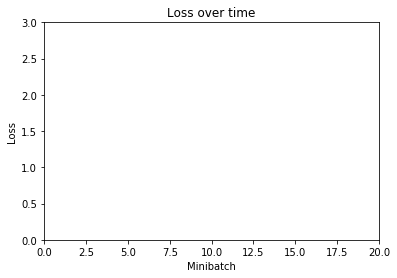

current minibatch loss 4.87002801895 progress: 6.96 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.79153060913 progress: 13.91 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.73096895218 progress: 20.87 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.67351913452 progress: 27.82 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.59616374969 progress: 34.78 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.545566082 progress: 41.74 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.51279878616 progress: 48.69 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.47289991379 progress: 55.65 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.40781021118 progress: 62.61 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 4.35280895233

In [0]:
prop = NetProperties(64, 32, 32, 200, 1000, 7)
dataset = DataSet();
network = Network(prop, dataset)
network.train()
network.save("/content/drive/My Drive/NLP/model.md5")

In [47]:
network.load("/content/drive/My Drive/NLP/model.md5")
tag2action = dict(zip(vocabs_action.iloc[:,1], vocabs_action.iloc[:,0]))
network.decode(dataset.word_dev, dataset.pos_dev, dataset.label_dev)

['RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det',
 'RIGHT-ARC:appos',
 'RIGHT-ARC:det',
 'RIGHT-ARC:det']